# Introduction to Metropolis MCMC

Metropolis Markov chain Monte Carlo is a method for sampling from a distribution where direct sampling is difficult. Such difficulties usually come about in fields with high dimensions and with prior distributions in Bayesian work-flow.  The Metropolis algorithm is as follows.

1. Create a random initialization point $x_0$ and decide on candidate distribution function $g(x'|x)$. The Metropolis algorithm requires that $g$ must be symmetric, so $g(x'|x)=g(x|x')$ for all $x$ and $x'$.

2. For each iteration of $t$.
    1. Generate a candidate $x'$ from $g(x'|x_t)$
    2. Calculate the acceptance ratio $\alpha=\frac{P(x'|y)}{P(x|y}$. Given that Log Probabilities, $LP(x|y)$, are often used,
    \begin{equation}
    \alpha=e^{LP(x'|y)-LP(x|y)}
    \end{equation}
    3. If $\alpha\ge 1$ then $x_{t+1}=x'$ else
       Pull a random number number from a Uniform distribution between 0 and 1 called $u$.
       \begin{equation}
       x_{t+1} = \begin{cases} x' & u\ge \alpha\\
       x_t & otherwise
       \end{cases}
       \end{equation}
        
The Metropolis algorithm is a special case of the Metropolis-Hastings algorithm. The Metropolis-Hastings algorithm includes $g(x'|x)$ in the calculation of $\alpha$, which allows for asymmetric candidate distributions.

If $P(x'|y)$ is greater than $P(x|y)$, the candidate is always accepted. This encourages the algorithm to turn back when it needs to, but it might discourage it from venturing far enough to properly describe the space. This can be especially problematic in the case of a multimodal distribution, where it might be hard to venture from one mode to the next. Multiple chains with different starting points can solve this issue, but the more modes there are, the more chains will be needed. On top of that, the mirage of a multimodal distributions might be a product of highly correlated data, where one parameter takes precedent over another and vice versa, rather than one large distribution.

Even with these problems, the Metropolis algorithm is useful one for many purposes. Let's take a look at the code.

# Tensorflow Code

As usual, we start by loading the packages and setting the seed.

In [1]:
import tensorflow as tf
import tensorflow.distributions as tfd
from tensorflow import contrib
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_random_seed(78)

The data is created with numpy so that it can be easily analyzed and reused. There will be a thousand points created froma standard normal distribution and the mean will be moved to 1.2.

Mean: 1.1923796476340627


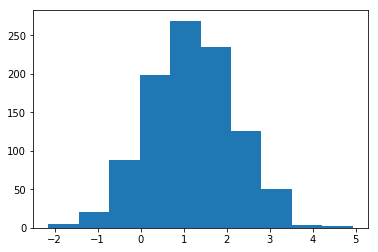

In [2]:
np.random.seed(78)
y_data = np.random.randn(1000) + 1.2
print("Mean: {}".format(np.mean(y_data)))
plt.hist(y_data)
plt.show
plt.show()

The data will be imported into Tensorflow by a placeholder called x. The jumps will be pre-decided. Our generative function will be $g(\mu'|\mu_t)=N(\mu_t, 0.1)$. Given that we don't have each $\mu_t$ yet we can make an array of jumps, $J\sim N(0, 0.1)$, so
\begin{equation}
g(\mu'|\mu_t) = \mu_t + j_t \sim N(0+\mu_t, 0.1) = N(\mu_t, 0.1)
\end{equation}

This is far from efficient if you have many dimensions and many samples, but the demands of this program won't come close to pushing the limits of a basic computer.

In [3]:
y = tf.placeholder(tf.float32)
J = tf.random_normal([1000], stddev=.1, dtype=tf.float32)

In this case, the initialization will be decided and calculated outside of the eventual jump function. Normally it would be randomly chosen by the computer, but this was defined for the sake of analysis.

In [4]:
init_mu = tf.constant(5., dtype=tf.float32)
init_dist = tfd.Normal(loc=init_mu, scale=1.)
init_lp = tf.reduce_sum(init_dist.log_prob(y))

Next, the jump function is defined. It takes two inputs: the prior output and the next jump. The prior output will be a tuple that includes the $x_t$ in the first slot and the log probability of $x_t$ in the second spot. The next jump will be our $j_t$ number.

The candidate is produced from the sum of the jump and the first element of the output, which is $x_t$. The candidate distribution and the candidate log probability are calculated from our candidate. In this case, we know the standard deviation is 1; we're only searching for the mean of this distribution.

Finally, the ratio is calculated and a flip is made. In theory, you could pre-calculate the flips along with the jumps. The jump function then returns the result of a condition. In TensorFlow, the outputs of a condition have to be functions.

In [5]:
def jump(output, next):
    candidate = output[0] + next
    cand_dist = tfd.Normal(loc=candidate, scale=1.)
    cand_lp = tf.reduce_sum(cand_dist.log_prob(y))
    ratio = tf.exp(cand_lp - output[1])
    flip = tf.random_uniform([1])[0]
    f1 = lambda: (candidate, cand_lp)
    f2 = lambda: (output[0], output[1])
    return tf.cond(flip < ratio, f1, f2)

A chain is created through a scan function. A scan function is usually used for recurrent neural networks, where a function uses the prior output in combination with the next input. This works perfectly for the needs of this experiment.

In [6]:
with tf.Session() as sess:
    test_one = sess.run(tf.scan(jump, J, initializer=(init_mu, init_lp)), feed_dict={y: y_data})

A quick look at the results. Only the last 500 results will be considered. The first 500 are a warmup leading into the final value.

Mean: 1.1933752298355103


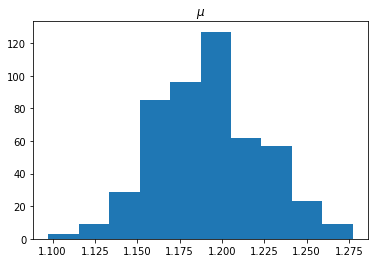

In [7]:
def summarise_result(result, warmup_ratio=.5, title='$\mu$'):
    result=result[int(warmup_ratio*result.shape[0]):]
    print('Mean: {}'.format(np.mean(result)))
    plt.hist(result)
    plt.title(title)
    return plt.show()
    
summarise_result(test_one[0])

A step graph function is create to quickly analyze our chain.

In [8]:
def step_graph(data, label=None, warmup=False, warmup_ratio=.5):
    if not warmup:
        data=data[int(warmup_ratio*data.shape[0]):]
    plt.plot(data)
    plt.title(label)
    return plt.show()

For starters, we'll look to see how the chain warmed up into its distribution, and then we'll take a closer look at the post warmup phase.

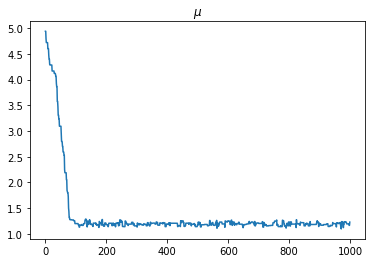

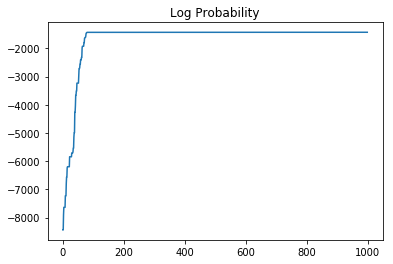

In [9]:
step_graph(test_one[0], label='$\mu$', warmup=True)
step_graph(test_one[1], label='Log Probability', warmup=True)

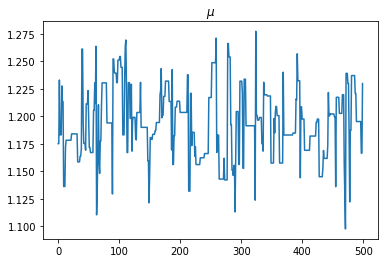

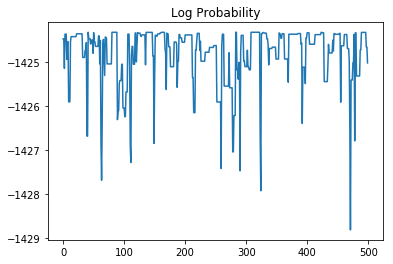

In [10]:
step_graph(test_one[0], label='$\mu$')
step_graph(test_one[1], label='Log Probability')

Lastly, we'll take a look at the comparison of the draws to the log probability. To no surprise, given that there is only one variable in a normal distribution, the graph displays a concave down quadratic function with it's peak at the mean of the data.

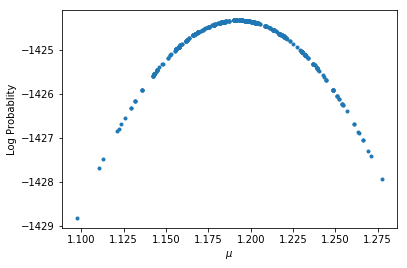

In [11]:
plt.plot(test_one[0][500:], test_one[1][500:], '.')
plt.xlabel('$\mu$')
plt.ylabel('Log Probablity')
plt.show()

In fact, if you run a quadratic regression from x to the log probability and find the Vertex, the x portion of the vertex is close to the mean of the data.

In [12]:
quadratic_x = np.stack([test_one[0], np.square(test_one[0]), np.ones(1000)])
quadratic_y = test_one[1]
lin_result = np.linalg.inv(quadratic_x @ quadratic_x.T) @ quadratic_x @ quadratic_y
print('Vertex of mu: {}'.format(-lin_result[0] / (2 * lin_result[1])))

Vertex of mu: 1.1923796565842126


## Changing The Jump Size & Shape

The size and shapes of the jumps can change the outcomes quite a bit. In this case, the standard devation of our normal jump will be increased and decreased, and then the shape will be changed to a uniform.

Mean: 1.1887929439544678


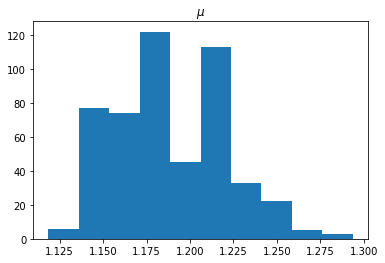

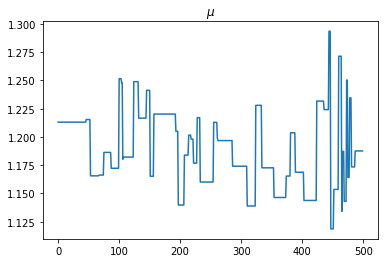

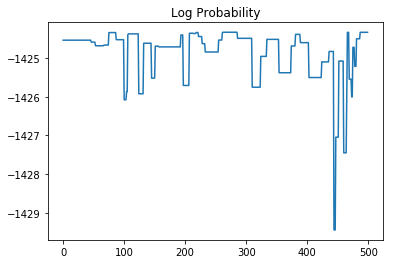

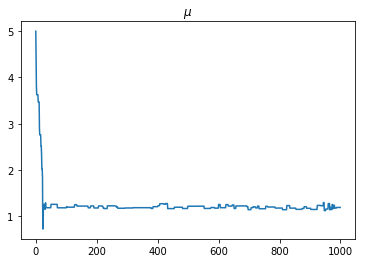

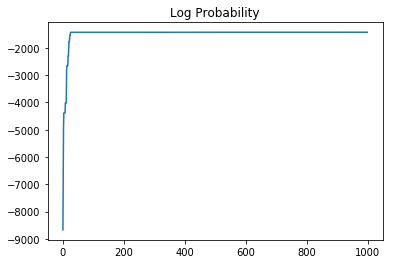

In [13]:
J_two = tf.random_normal([1000], stddev=.5, dtype=tf.float32)

with tf.Session() as sess:
    test_two = sess.run(tf.scan(jump, J_two, initializer=(init_mu, init_lp)), feed_dict={y: y_data})
    
summarise_result(test_two[0])
step_graph(test_two[0], label='$\mu$')
step_graph(test_two[1], label='Log Probability')
step_graph(test_two[0], label='$\mu$', warmup=True)
step_graph(test_two[1], label='Log Probability', warmup=True)

The chain converges on the center quicker but has a tendency to sit, which creates an uneven distribution with certain portions having for more samples than they should. For instance, here are the number of unique variables out of the 500.

In [14]:
print("# of unique samples:", np.unique(test_two[0]).shape[0])

# of unique samples: 96


Mean: 1.193144679069519


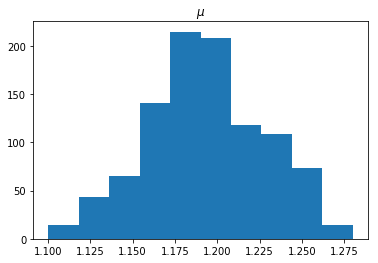

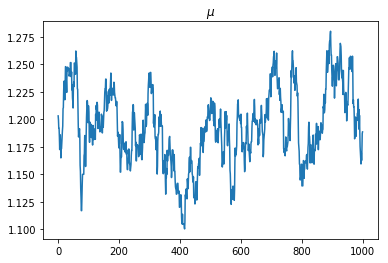

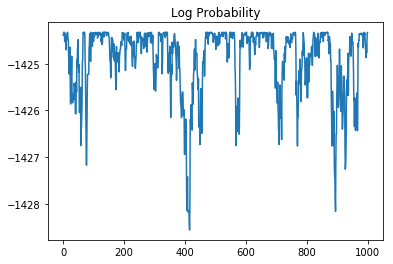

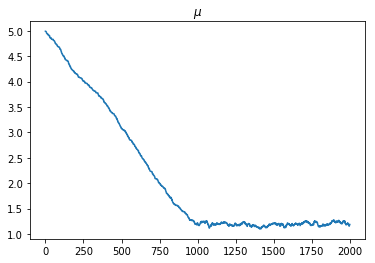

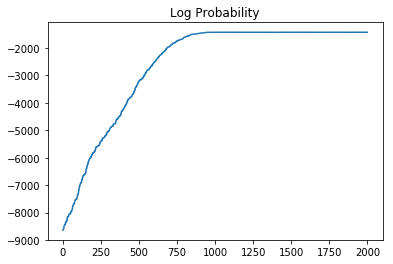

In [15]:
J_three = tf.random_normal([2000], stddev=.01, dtype=tf.float32)

with tf.Session() as sess:
    test_three = sess.run(tf.scan(jump, J_three, initializer=(init_mu, init_lp)), feed_dict={y: y_data})
    
summarise_result(test_three[0])
step_graph(test_three[0], label='$\mu$')
step_graph(test_three[1], label='Log Probability')
step_graph(test_three[0], label='$\mu$', warmup=True)
step_graph(test_three[1], label='Log Probability', warmup=True)

In the case of a small jump, the number of jumps had to be doubles to make up for the amount of time it takes to converge on the mean, but, once it gets there, it does a good job of sampling the space. Finally, here are the results of a uniform jump. The results are far from inadequate.

Mean: 1.190693974494934


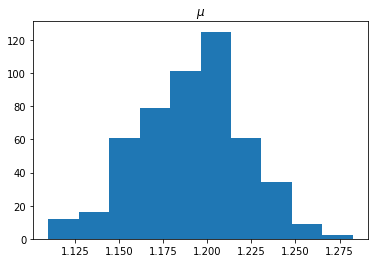

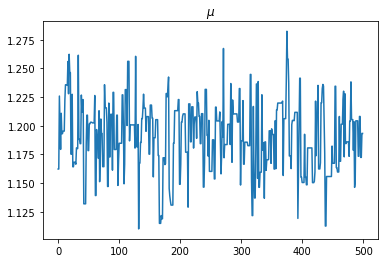

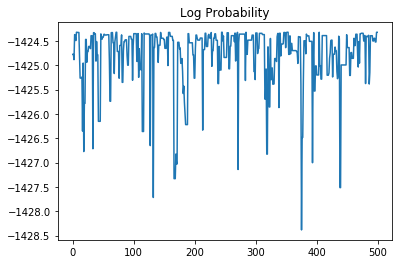

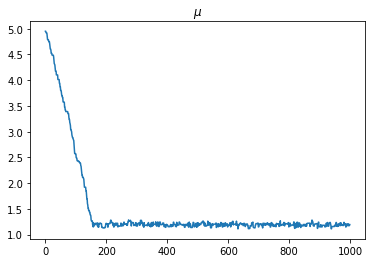

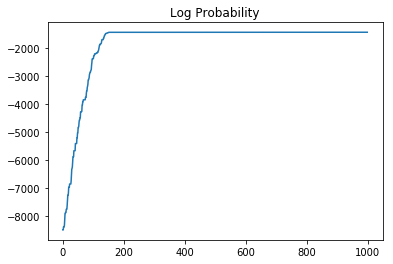

In [16]:
J_four = tf.random_uniform([1000], minval=-.1, maxval=.1, dtype=tf.float32)

with tf.Session() as sess:
    test_four = sess.run(tf.scan(jump, J_four, initializer=(init_mu, init_lp)), feed_dict={y: y_data})
    
summarise_result(test_four[0])
step_graph(test_four[0], label='$\mu$')
step_graph(test_four[1], label='Log Probability')
step_graph(test_four[0], label='$\mu$', warmup=True)
step_graph(test_four[1], label='Log Probability', warmup=True)

## Linear Regression

Next up, a sample from a simple linear regression model will be taken. Once again, the standard deviation, the error in this case, will be known.

The linear regression model will look like so
\begin{equation}
y \sim N(2.7 + 0.4x, 1)
\end{equation}

The sampling will be taken from 
\begin{equation}
y \sim N(\alpha + \beta x, 1)
\end{equation}

Specifically, the $\alpha$ and $\beta$ parameters.

For starters, new data has to be created an x placeholder will also have to be added. 

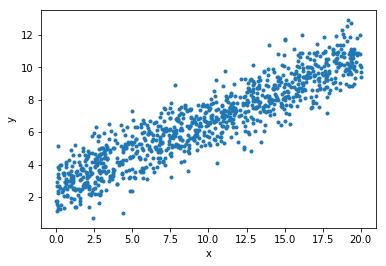

In [17]:
np.random.seed(555)
x_data = (np.random.rand(1000) * 20).astype(np.float32)
y_data_two = 2.7 + x_data * .4 + np.random.randn(1000)

plt.plot(x_data, y_data_two, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [18]:
x = tf.placeholder(tf.float32, name='x')

Next, the jumps are made in the for of a 1000 X 2 matrix. The first column will be the jump for the $\alpha$, and the second column will be the jump for the $\beta$. If a jump fails, both the $\alpha$ and the $\beta$ remain the same even if one should have moved. 

In [19]:
J_five = tf.random_uniform([1000, 2], minval=-.09, maxval=.09, dtype=tf.float32)

The initialized now includes two inputs. One of the inputs will be much further away from its result than the other. We will see why we are doing this later. The calculation of the $\mu$ inside of the normal function was described earlier. Instead of having one $\mu$ that answers for all y, there is a single $\mu$ for each y. There is essentially 1000 Normal distributions with a mean of $\mu=\alpha + \beta x$ and standard deviation of 1. A column of ones could have been stacked onto the x vector, and the second initialization $\mu$ could have been matrix multiplied against that, but it was written this way for readability.

In [20]:
init_mu_two = tf.constant([5., -1.3], dtype=tf.float32)
init_dist_two = tfd.Normal(loc=init_mu_two[0] + init_mu_two[1] * x, scale=1.)
init_lp_two = tf.reduce_sum(init_dist_two.log_prob(y))

The only thing that has chaged in our jump function is the calculation of the $\mu=\alpha + \beta x$ in the Normal distribution. All other things are the same.

In [21]:
def jump_two(output, next):
    candidate = output[0] + next
    cand_dist = tfd.Normal(loc=candidate[0] + candidate[1] * x, scale=1.)
    cand_lp = tf.reduce_sum(cand_dist.log_prob(y))
    ratio = tf.exp(cand_lp - output[1])
    flip = tf.random_uniform([1])[0]
    f1 = lambda: (candidate, cand_lp)
    f2 = lambda: (output[0], output[1])
    return tf.cond(flip < ratio, f1, f2)

In [22]:
with tf.Session() as sess:
    test_five = sess.run(tf.scan(jump_two, J_five, initializer=(init_mu_two, init_lp_two)), feed_dict={y: y_data_two, x: x_data})

A quick look at the data:

Mean: 2.825465679168701


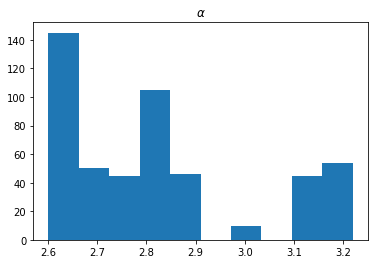

Mean: 0.39315539598464966


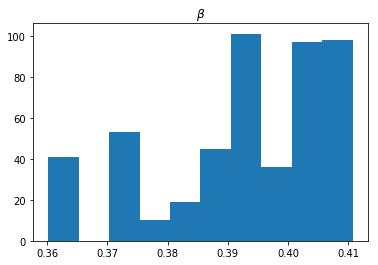

In [23]:
summarise_result(test_five[0][:,0], title=r'$\alpha$')
summarise_result(test_five[0][:,1], title=r'$\beta$')

The data is skewed. The reason for this can be seen in the Step graph that includes the warm-up. It takes longer for the $\alpha$ parameter to reach its destination since it is further away than the $\beta$ parameter is from its destination. 

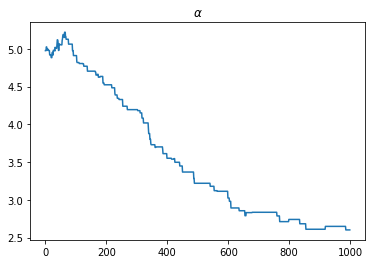

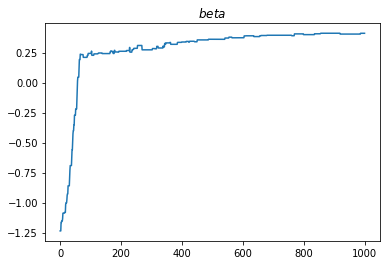

In [24]:
step_graph(test_five[0][:,0], warmup=True, label=r"$ \alpha $")
step_graph(test_five[0][:,1], warmup=True, label=r'$beta$')

Even when it reaches its desitination, it doesn't move around much.

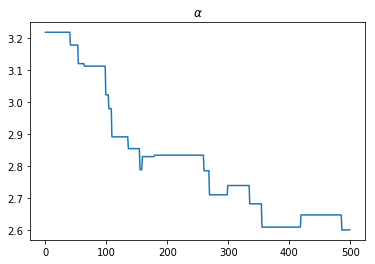

In [25]:
step_graph(test_five[0][:,0], warmup=False, label=r'$\alpha$')

To solve this, the jumps are going to start out much larger and then convert to much smaller jumps. Specifically the first 400 jumps will have a uniform distribution from -1 to 1. The next 1600 jumps, 600 of which will still be warmups, will have a uniform distribution from -0.02 to 0.02. All other things will be left the same.

In [26]:
J_six = tf.concat([tf.random_uniform([400, 2], minval=-1., maxval=1., dtype=tf.float32), tf.random_uniform([1600, 2], minval=-.02, maxval=.02)], 0)

with tf.Session() as sess:
    test_six = sess.run(tf.scan(jump_two, J_six, initializer=(init_mu_two, init_lp_two)), feed_dict={y: y_data_two, x: x_data})

Now the jumps quickly find their mark well before the 400 mark and have room for any necessary easing before the 1000 mark. In this case, data could be used from the last 1500 jumps, but the last 1000 will be more than sufficient enough.

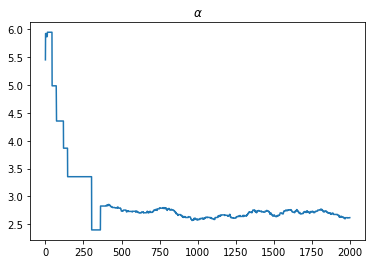

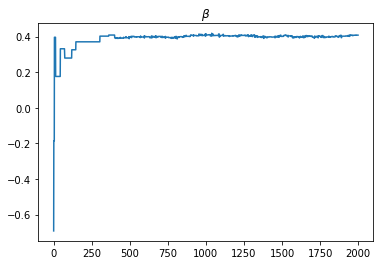

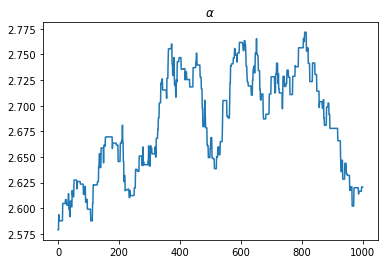

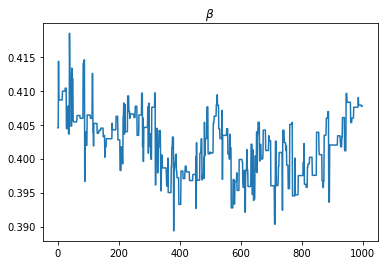

In [27]:
step_graph(test_six[0][:,0], warmup=True, label=r'$\alpha$')
step_graph(test_six[0][:,1], warmup=True, label=r'$\beta$')
step_graph(test_six[0][:,0], label=r'$\alpha$')
step_graph(test_six[0][:,1], label=r'$\beta$')

Mean: 2.682262659072876


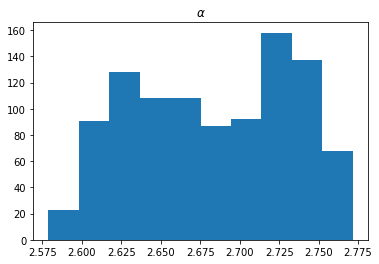

Mean: 0.4020470678806305


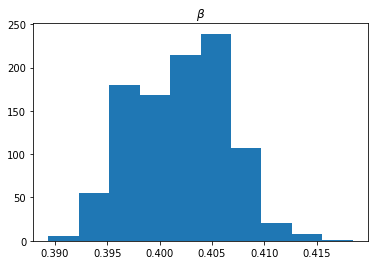

In [28]:
summarise_result(test_six[0][:,0], title=r"$\alpha$")
summarise_result(test_six[0][:,1], title=r"$\beta$")

The Random Walk Metropolis algorithm does a good enough job of exploring the space but sometimes gets carried away in the direction it's going. After the algorithm gets to a certain point, it's unlikely for it to continue on, but there is still the possibility of the algorithm turning around twice and exploring a little too much of one side of the space. This can Usually, this can be solved by having multiple chains. It is likely that one of the chains will explore the other end of the state space. This assumes the distribution isn't skewed to begin with. 

Lastly, a bivariate graph to see how the space was explored by both. Overall, it centers around what would be expected, but there is definitely some missing information that can be found with multiple chains.

C:\Users\verhalenn\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


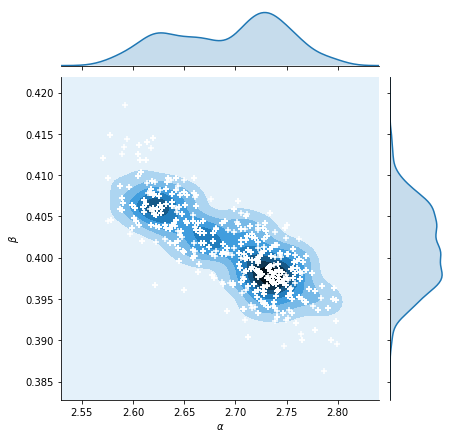

In [29]:
import seaborn as sns
sns.jointplot(test_six[0][:,0][500:], test_six[0][:,1][500:], kind='kde').plot_joint(plt.scatter, color='w', marker='+').set_axis_labels(r'$\alpha$', r'$\beta$')

## Conclusions

The Metropolis algorithm, like any algorithm, has its flaws. There is a lot of work when it comes to trying to find the right jump distance, and there is no guarantee that the algorithm explores everything that it needs to. In fact, there is no denying that there are much better algorithms, but the Metropolis algorithm sets the stage for many of those and is an important and interesting study. 